Epoch 1, Loss: 1.2535, Validation Accuracy: 0.76%
Epoch 2, Loss: 0.7041, Validation Accuracy: 0.82%
Epoch 3, Loss: 0.5906, Validation Accuracy: 0.82%
Epoch 4, Loss: 0.5080, Validation Accuracy: 0.90%
Epoch 5, Loss: 0.3876, Validation Accuracy: 0.90%
Epoch 6, Loss: 0.3979, Validation Accuracy: 0.93%
Epoch 7, Loss: 0.3517, Validation Accuracy: 0.95%
Epoch 8, Loss: 0.3379, Validation Accuracy: 0.95%
Epoch 9, Loss: 0.2522, Validation Accuracy: 0.95%
Epoch 10, Loss: 0.2790, Validation Accuracy: 0.95%

Final Classification Report:
              precision    recall  f1-score   support

    CALCULUS       0.94      0.96      0.95        82
   TOOTH ISC       0.88      0.95      0.91        62
  GINGIVITIS       0.98      0.92      0.95        66
    CARRIERS       0.93      0.90      0.92        61
 MOUTH ULCER       1.00      0.98      0.99        61

    accuracy                           0.95       332
   macro avg       0.95      0.94      0.95       332
weighted avg       0.95      0.95  

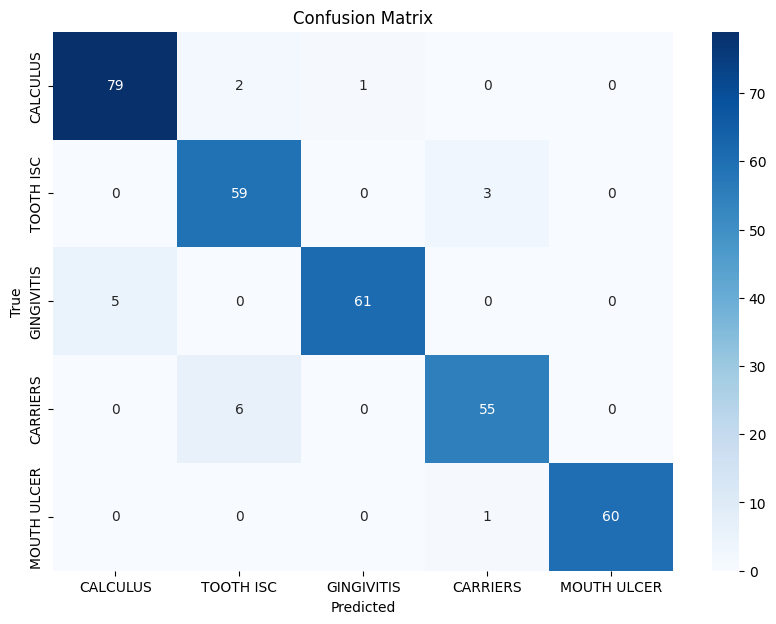

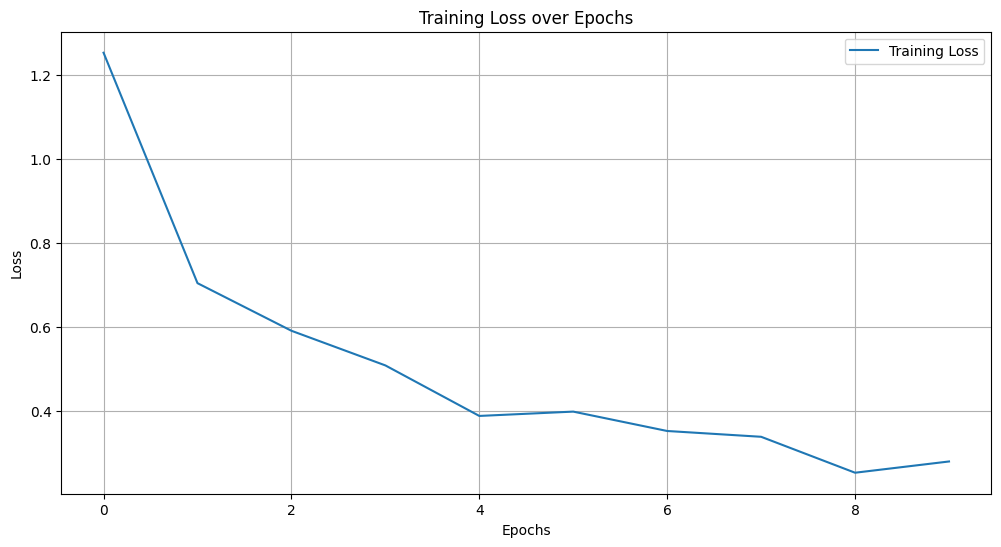

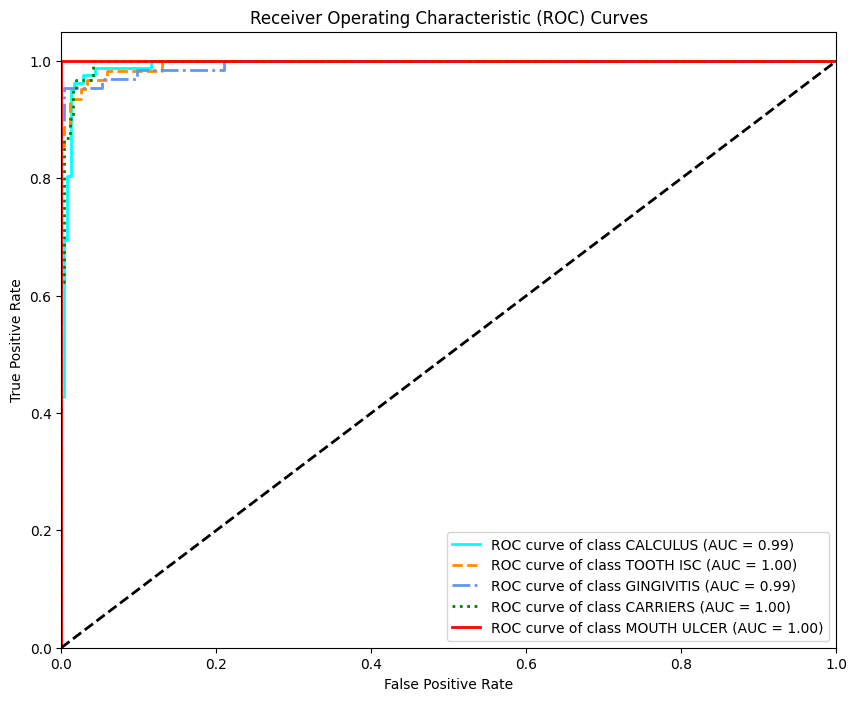

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import densenet201, DenseNet201_Weights  # Updated import for weights
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import seaborn as sns

# Define dataset path
dataset_path = '/content/drive/MyDrive/minor/ATA/ATA'

# Define enhanced data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomVerticalFlip(),  # New transformation
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # New transformation
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Custom dataset class
class OralDiseaseDataset(Dataset):
    def __init__(self, dataset_path, transform, split='train', val_split=0.2):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = os.listdir(dataset_path)

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(dataset_path, class_name)
            images = os.listdir(class_path)
            random.shuffle(images)

            # Filter out directories
            images = [img for img in images if os.path.isfile(os.path.join(class_path, img))]

            # Split dataset into training and validation
            split_idx = int(len(images) * (1 - val_split))
            if split == 'train':
                selected_images = images[:split_idx]
            else:
                selected_images = images[split_idx:]

            for image_name in selected_images:
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure image is RGB
        image = self.transform(image)
        return image, label


# Create train and validation datasets
train_dataset = OralDiseaseDataset(dataset_path, data_transforms['train'], split='train')
val_dataset = OralDiseaseDataset(dataset_path, data_transforms['val'], split='val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define DenseNet-201 model with Dropout layer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = DenseNet201_Weights.DEFAULT  # Use default weights
model = densenet201(weights=weights)
num_classes = len(train_dataset.classes)

# Add dropout layer to reduce overfitting
model.classifier = nn.Sequential(
    nn.Linear(1920, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout with 50% probability
    nn.Linear(512, num_classes)
)
model = model.to(device)

# Define loss function, optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Added L2 regularization

# Training setup
num_epochs = 10  # Set to 10 epochs
train_losses = []
val_accuracies = []

# Train model
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate model on validation set
    model.eval()
    predicted_labels = []
    true_labels = []
    predicted_probabilities = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_probabilities.append(torch.softmax(outputs, dim=1).cpu().numpy())

    predicted_probabilities = np.vstack(predicted_probabilities)

    # Calculate final accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    val_accuracies.append(accuracy)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

# Final consolidated classification report
print("\nFinal Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot Training Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Final Evaluation on Validation Set
# ROC Curve and AUC
true_labels_binarized = label_binarize(true_labels, classes=np.arange(num_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC with Distinguishable Colors and Line Styles
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
linestyles = cycle(['-', '--', '-.', ':', '-'])  # Different line styles
for i, color, ls in zip(range(num_classes), colors, linestyles):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, linestyle=ls,
             label=f'ROC curve of class {train_dataset.classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()